ref: https://www.kaggle.com/erikistre/pytorch-basic-u-net

# 比赛名次---Fight!!! 思路最重要

![](http://op4a94iq8.bkt.clouddn.com/18-8-28/35876898.jpg)
### basic u-net 严重过拟合  没有测试时平均 0.835阈值
![](http://op4a94iq8.bkt.clouddn.com/18-8-29/4992953.jpg)
![](http://op4a94iq8.bkt.clouddn.com/18-8-29/39579386.jpg)
![](http://op4a94iq8.bkt.clouddn.com/18-8-29/87840458.jpg)

# FAQ:

<font size=4.5 color=bblue> 若使用U-Net系列网络，因为一般是下采样5次，故要求输入图片的宽和高是32的倍数，我们的原始数据的101x101的，所以resize到离101最近的32的倍数，也就是128x128, 不过在后续还可以尝试使用padding的方式填充到128，而不用缩放

<font size=4.5 color=bblue>改进的切入点:  (务必保证模块化替换，代码简单逻辑清晰便于修改) 
* 数据处理环节
    * 如果使用预训练模型 那么对图片的归一化处理必须与其一致   
    
    * 使用0填充形式的resize，使用左右水平翻转增广数据，在测试阶段使用左右水平翻转平均预测  
    ``` python
    # resize image (101,101) -> (128,128)
    def image_in(img):    
        out = np.zeros((128,128), dtype=np.uint8)    
        ih = img[:, ::-1] 
        iv = img[::-1, :]
        ihv= ih[::-1, :] 
        out[13:114, 13:114] = img    
        out[0:13,0:13] = ihv[-13:,-13:]
        out[0:13,13:114] = iv[-13:,:]
        out[0:13, -14:] = ihv[-13:, 0:14]
        out[13:114, 0:13] = ih[:,-13:]
        out[-14:, 0:13] = ihv[0:14:,-13:]
        out[-14:,13:114] = iv[0:14,:]
        out[-14:,-14:] = ihv[0:14,0:14]
        out[13:114,-14:]  =ih[:,0:14]
        return(out)
     
    # go back to original size (128,128) -> (101,101) 
    def image_out(img):
        return img[13:114,13:114]   # for 4 dims use [:,13:114,13:114,:]
        
    # instead using heavy augmentations, 
    # flip left-right is simple and maybe is the only method allowed
    def flip():
        X_aug = X_train[:,:,::-1,:]
        y_aug = y_train[:,:,::-1,:]    
        
    # this is tricky
    # having pyotrch model trained, even with augmented left-right data, 
    # try predict with normal and mirrored X_test and take the average
    def dummy_prediction():
        # ...
        y_preds = model.predict(X_test, verbose=0)
        if mirror==True:
            m_preds = model.predict(X_test[:,:,::-1,:], verbose=0)
            y_preds = 0.5 * (y_preds + m_preds[:,:,::-1,:])
    
    ```
    
   
* 网络架构设计环节
    * 这个可以查Kaggle、谷歌学术相关比赛论文(这些论文一般5-6页)、github上找开源Pytorch代码
    
* 对logits解码和ground truth的loss计算环节
    * 设计多任务Loss函数
     
* 优化器设置 学习步长设置环节
    * Fast.ai 出品的加速收敛的工具包
    * 多阶段学习率
    * 各种优化器 
    * Added dropout to the model which seems to improve performance.
    * 训练方法: 先freeze encoder参数，训练decoder参数，最后整体微调    
    
* 保存和加载参数、记录信息、给训练和测试阶段加点计时代码

# Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from glob import glob
import sys
import random

from tqdm import tqdm_notebook  # 在jupyter-notebook中展示精度条时，只能使用 tqdm_notebook
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.metrics import jaccard_similarity_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from torch.autograd import Variable

# Image Preparation

In [2]:
# Set some parameters# Set s 
im_width = 128
im_height = 128
im_chan = 3  # 通道数是1？？？？
path_train = 'TrainData'
path_test = 'TestData'

train_path_images = os.path.abspath(path_train + "/images/")
train_path_masks = os.path.abspath(path_train + "/masks/")

test_path_images = os.path.abspath(path_test + "/images/")
test_path_masks = os.path.abspath(path_test + "/masks/")

In [3]:
train_path_images_list = glob(os.path.join(train_path_images, "*.png"))
train_path_masks_list = glob(os.path.join(train_path_masks, "*.png"))
test_path_images_list = glob(os.path.join(test_path_images, "*.png"))
test_path_masks_list = glob(os.path.join(test_path_masks, "*.png"))

(101, 101, 3)
(101, 101)
(101, 101, 3)
(101, 101)
(101, 101, 3)
(101, 101)
(101, 101, 3)
(101, 101)
(101, 101, 3)
(101, 101)


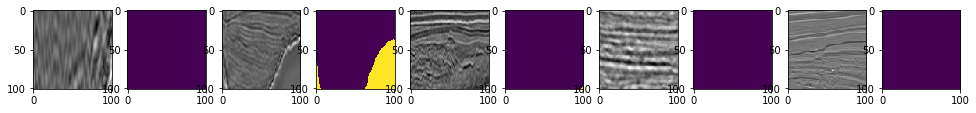

[[[117 117 117]
  [118 118 118]
  [119 119 119]
  ...
  [110 110 110]
  [107 107 107]
  [107 107 107]]

 [[119 119 119]
  [118 118 118]
  [117 117 117]
  ...
  [ 96  96  96]
  [ 96  96  96]
  [ 98  98  98]]

 [[114 114 114]
  [114 114 114]
  [114 114 114]
  ...
  [105 105 105]
  [105 105 105]
  [104 104 104]]

 ...

 [[112 112 112]
  [113 113 113]
  [112 112 112]
  ...
  [116 116 116]
  [121 121 121]
  [117 117 117]]

 [[125 125 125]
  [119 119 119]
  [113 113 113]
  ...
  [120 120 120]
  [123 123 123]
  [127 127 127]]

 [[126 126 126]
  [119 119 119]
  [117 117 117]
  ...
  [104 104 104]
  [101 101 101]
  [112 112 112]]]


In [4]:
# 展示训练集中的几张图片
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = imread(train_path_images + "/" + img_name + '.png')
    print(img.shape)
    img_mask = imread(train_path_masks + "/" + img_name + '.png')
    print(img_mask.shape)
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()
print(img) # 颜色数组中的RGB上对应的位置都相同 故可以只保存1个通道 压缩保存

In [5]:
train_ids = next(os.walk(train_path_images))[2]
test_ids = next(os.walk(test_path_images))[2]
print(len(list(train_ids))) #生成器类型  生成字符串 "xxxxxxxxx.png"
print(len(list(test_ids)))  # 同上

4000
18000


In [6]:
#---------------  Get Training Images and resize train images and masks ------------------------------
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool_)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    img = imread(path_train + '/images/' + id_)
    if n==1: 
        print("raw img shape:",img.shape)  # 打印其中的1张图片的原始shape   # 由于颜色数组中的RGB上对应的位置都相同 故可以只保存1个通道 压缩保存
    x = resize(img, (128, 128, 3), mode='constant', preserve_range=True)  # 缩放至128x128x1 
    X_train[n] = x
    mask = imread(path_train + '/masks/' + id_)
    Y_train[n] = resize(mask, (128, 128, 1), 
                        mode='constant', 
                        preserve_range=True)

print('Done!')
print('X_train：',X_train.shape)
print("Y_train：",Y_train.shape)

Getting and resizing train images and masks ... 


A Jupyter Widget

raw img shape: (101, 101, 3)

Done!
X_train： (4000, 128, 128, 3)
Y_train： (4000, 128, 128, 1)


(128, 128, 3)


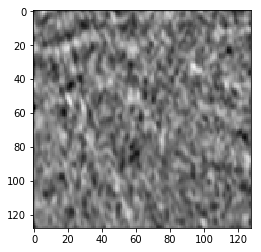

mask: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(128, 128, 3)


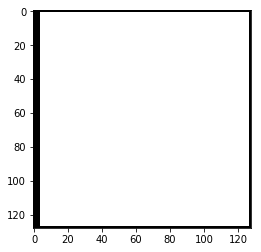

(128, 128, 3)


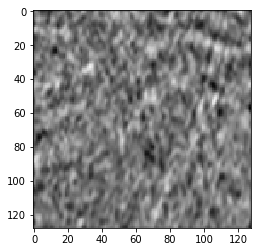

(128, 128, 3)


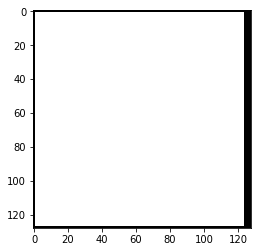

In [14]:
# Check if training data looks all right
ix =random.randint(0, len(train_ids))
print((X_train[ix].shape))
bb=X_train[ix].copy()
plt.imshow(bb) # X_train是1通道压缩保存，stack到3通道才能正常展示图片
plt.show()

tmp = np.squeeze(Y_train[ix]).astype(np.float32)
print("mask:",tmp)
cc=np.dstack((tmp,tmp,tmp))
print(cc.shape)
plt.imshow(cc)
plt.show()

bb=bb.transpose(2,0,1)
cc=cc.transpose(2,0,1)

# instead using heavy augmentations, 
# flip left-right is simple and maybe is the only method allowed
def flip():
#     X_aug = bb[:,::-1,:]
#     y_aug = cc[:,::-1,:]  
    X_aug = bb[:,:,::-1]
    y_aug = cc[:,:,::-1]  
    return X_aug,y_aug

X_aug,y_aug=flip() #[c,h,w]
X_aug=X_aug.transpose(1,2,0)
y_aug=y_aug.transpose(1,2,0)

print((X_aug.shape))
plt.imshow(X_aug) # X_train是1通道压缩保存，stack到3通道才能正常展示图片
plt.show()


print(y_aug.shape)
plt.imshow(y_aug)
plt.show()
    

# Prepare Images for Pytorch

In [15]:
# 自定义一个Pytorch的数据加载器,必须继承自torch.utils.data.Dataset
# https://stackoverflow.com/questions/50052295/how-do-you-load-images-into-pytorch-dataloader

class saltIDDataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images,train=True, preprocessed_masks=None):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.train = train
        self.images = preprocessed_images
        if self.train:
            self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
        return (image, mask)

### <font color=bblue>输入归一化 注意如果使用预训练的模型 则输入的归一化方法就不是下面这种（负责效果很差） 而要使用标准处理代码

In [16]:
from torchvision.transforms import ToTensor, Normalize, Compose

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# img_transform = Compose([
#     ToTensor(),
#     Normalize(mean=[0.485,], std=[0.229,])
# ])

img_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [17]:
X_train_shaped = X_train.copy().reshape(-1, 3, 128, 128)/255.0  # 线性归一化 (0,1)区间
Y_train_shaped = Y_train.copy().reshape(-1, 1, 128, 128)

X_train_shaped = X_train_shaped.astype(np.float32)
Y_train_shaped = Y_train_shaped.astype(np.float32)

In [18]:
X_train_shaped.shape

(4000, 3, 128, 128)

In [19]:
X_train_shaped=X_train_shaped.transpose(0,2,3,1)
Y_train_shaped=Y_train_shaped.transpose(0,2,3,1)
print("Before:",X_train_shaped.shape)

Before: (4000, 128, 128, 3)


In [20]:
X_train_shaped_1=np.zeros((X_train_shaped.shape[0],X_train_shaped.shape[3],X_train_shaped.shape[1],X_train_shaped.shape[2]),dtype=np.float32)
Y_train_shaped_1=np.zeros((Y_train_shaped.shape[0],Y_train_shaped.shape[3],Y_train_shaped.shape[1],Y_train_shaped.shape[2]),dtype=np.float32)

for idx,sample in tqdm_notebook(enumerate(X_train_shaped),total=len(X_train_shaped)):
    if idx==0:
        print(img_transform(sample).shape)  # 输入图片是【H,W,C】 转换结果是【C,H,W】
    #X_train_shaped_1[idx]=img_transform(sample)
    X_train_shaped_1[idx]= sample.transpose(2,0,1)
    
for idx,sample in tqdm_notebook(enumerate(Y_train_shaped),total=len(Y_train_shaped)):
    Y_train_shaped_1[idx]= sample.transpose(2,0,1)  # 不要对y进行标准归一化处理
    
print(X_train_shaped_1.shape)
print(X_train_shaped_1[0])
print(Y_train_shaped_1.shape)
print(Y_train_shaped_1[0])

A Jupyter Widget

torch.Size([3, 128, 128])



A Jupyter Widget


(4000, 3, 128, 128)
[[[-0.9876702  -0.9876702  -0.9876702  ... -0.42255333 -0.4739276
   -0.4739276 ]
  [-0.4739276  -0.5081771  -0.5081771  ... -0.5081771  -0.5081771
   -0.6280504 ]
  [-0.6280504  -0.6280504  -0.69654936 ... -1.0219197  -1.0219197
   -1.0219197 ]
  ...
  [-0.5253019  -0.5253019  -0.43967807 ... -1.141793   -1.141793
   -1.141793  ]
  [-0.57667613 -0.57667613 -0.57667613 ... -0.42255333 -0.30268008
   -0.30268008]
  [-0.30268008 -0.26843056 -0.26843056 ... -0.16568205 -0.16568205
   -0.38830382]]

 [[-0.26750696 -0.26750696 -0.28501397 ... -0.705182   -0.705182
   -0.705182  ]
  [-0.30252096 -0.30252096 -0.30252096 ... -0.33753496 -0.23249297
   -0.23249297]
  [-0.23249297 -0.17997196 -0.17997196 ...  0.45028022  0.45028022
    0.29271722]
  ...
  [-0.460084   -0.44257697 -0.44257697 ... -0.19747896 -0.19747896
   -0.14495796]
  [-0.14495796 -0.14495796 -0.12745096 ... -0.897759   -0.897759
   -0.897759  ]
  [-0.862745   -0.862745   -0.862745   ... -0.84523803 -0.705

# Data Augmention

In [21]:
X_train_shaped_2 =X_train_shaped_1.copy()
Y_train_shaped_2=Y_train_shaped_1.copy()
print(X_train_shaped_2 is X_train_shaped_1)
print(Y_train_shaped_2 is Y_train_shaped_1)

False
False


In [22]:
def Flip(X,Y):
#     X_aug = bb[:,::-1,:]
#     y_aug = cc[:,::-1,:]  
    X_aug = X[:,:,:,::-1]
    y_aug = Y[:,:,:,::-1]  
    return X_aug,y_aug

X_train_shaped_2,Y_train_shaped_2=Flip(X_train_shaped_2,Y_train_shaped_2)

In [23]:
X_train_shaped_3=np.concatenate([X_train_shaped_1,X_train_shaped_2],axis=0)
Y_train_shaped_3=np.concatenate([Y_train_shaped_1,Y_train_shaped_2],axis=0)
print(X_train_shaped_3.shape)
print(Y_train_shaped_3.shape)

(8000, 3, 128, 128)
(8000, 1, 128, 128)


### 设置全局固定随机种子方便复现

In [24]:
torch.cuda.manual_seed_all(4200)
np.random.seed(133700)

In [25]:
indices = list(range(len(X_train_shaped_3)))
np.random.shuffle(indices)  # 打乱样本索引

val_size = 1/10  # 取训练数据的1/10样本作为验证集样本
split = np.int_(np.floor(val_size * len(X_train_shaped_3)))
print("How many samples are used as validation set:",split)

train_idxs = indices[split:]
val_idxs = indices[:split]

How many samples are used as validation set: 800


### 构造数据载入器

In [26]:
X_train_shaped_3[train_idxs].shape


(7200, 3, 128, 128)

In [27]:
Y_train_shaped_3[train_idxs].shape

(7200, 1, 128, 128)

In [28]:
salt_ID_dataset_train = saltIDDataset(X_train_shaped_3[train_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped_3[train_idxs])

salt_ID_dataset_val = saltIDDataset(X_train_shaped_3[val_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped_3[val_idxs])


batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=False)



# 定义模型 ----------------------- core 

### 模型1：标准u-net

In [29]:
class double_conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True), 
            
                    nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True))
        
    def forward(self, x):
        x = self.conv(x)
        return x
        
start_fm = 16 # 这样的好处是，调节它控制各层通道数，也就是宽度

class Unet(nn.Module):
    
    def __init__(self):
        super(Unet, self).__init__()
        
        # Input 128x128x1
        
        #Contracting Path
        
        #(Double) Convolution 1        
        self.double_conv1 = double_conv(3, start_fm, 3, 1, 1)
        #Max Pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 2
        self.double_conv2 = double_conv(start_fm, start_fm * 2, 3, 1, 1)
        #Max Pooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 3
        self.double_conv3 = double_conv(start_fm * 2, start_fm * 4, 3, 1, 1)
        #Max Pooling 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 4
        self.double_conv4 = double_conv(start_fm * 4, start_fm * 8, 3, 1, 1)
        #Max Pooling 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 5
        self.double_conv5 = double_conv(start_fm * 8, start_fm * 16, 3, 1, 1)
        
        #Transposed Convolution 4
        self.t_conv4 = nn.ConvTranspose2d(start_fm * 16, start_fm * 8, 2, 2)
        # Expanding Path Convolution 4 
        self.ex_double_conv4 = double_conv(start_fm * 16, start_fm * 8, 3, 1, 1)
        
        #Transposed Convolution 3
        self.t_conv3 = nn.ConvTranspose2d(start_fm * 8, start_fm * 4, 2, 2)
        #Convolution 3
        self.ex_double_conv3 = double_conv(start_fm * 8, start_fm * 4, 3, 1, 1)
        
        #Transposed Convolution 2
        self.t_conv2 = nn.ConvTranspose2d(start_fm * 4, start_fm * 2, 2, 2)
        #Convolution 2
        self.ex_double_conv2 = double_conv(start_fm * 4, start_fm * 2, 3, 1, 1)
        
        #Transposed Convolution 1
        self.t_conv1 = nn.ConvTranspose2d(start_fm * 2, start_fm, 2, 2)
        #Convolution 1
        self.ex_double_conv1 = double_conv(start_fm * 2, start_fm, 3, 1, 1)
        
        # One by One Conv
        self.one_by_one = nn.Conv2d(start_fm, 1, 1, 1, 0)
        #self.final_act = nn.Sigmoid()
        
        
    def forward(self, inputs):
        # Contracting Path
        conv1 = self.double_conv1(inputs)
        maxpool1 = self.maxpool1(conv1)

        conv2 = self.double_conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)

        conv3 = self.double_conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)

        conv4 = self.double_conv4(maxpool3)
        maxpool4 = self.maxpool4(conv4)
            
        # Bottom
        conv5 = self.double_conv5(maxpool4)
        
        # Expanding Path
        t_conv4 = self.t_conv4(conv5)
        cat4 = torch.cat([conv4 ,t_conv4], 1)
        ex_conv4 = self.ex_double_conv4(cat4)
        
        t_conv3 = self.t_conv3(ex_conv4)
        cat3 = torch.cat([conv3 ,t_conv3], 1)
        ex_conv3 = self.ex_double_conv3(cat3)

        t_conv2 = self.t_conv2(ex_conv3)
        cat2 = torch.cat([conv2 ,t_conv2], 1)
        ex_conv2 = self.ex_double_conv2(cat2)
        
        t_conv1 = self.t_conv1(ex_conv2)
        cat1 = torch.cat([conv1 ,t_conv1], 1)
        ex_conv1 = self.ex_double_conv1(cat1)
        
        one_by_one = self.one_by_one(ex_conv1)
        
        return one_by_one

### 模型2：变种u-net   支持预训练权重

In [31]:
# #############################################
# ##  网络架构及Pytorch版本的Fine-tune手法   ##
# #############################################


# from torch import nn
# from torch.nn import functional as F
# import torch
# from torchvision import models
# import torchvision


# def conv3x3(in_, out):
#     return nn.Conv2d(in_, out, 3, padding=1)


# class ConvRelu(nn.Module):
#     def __init__(self, in_, out):
#         super().__init__()
#         self.conv = conv3x3(in_, out)
#         self.activation = nn.ReLU(inplace=True)

#     def forward(self, x):
#         x = self.conv(x)
#         x = self.activation(x)
#         return x


# class DecoderBlock(nn.Module):
#     def __init__(self, in_channels, middle_channels, out_channels):
#         super().__init__()

#         self.block = nn.Sequential(
#             ConvRelu(in_channels, middle_channels),
#             nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         return self.block(x)


# class UNet11(nn.Module):
#     def __init__(self, num_filters=32, pretrained=False):
#         """
#         :param num_classes:
#         :param num_filters:
#         :param pretrained:
#             False - no pre-trained network is used
#             True  - encoder is pre-trained with VGG11
#         """
#         super().__init__()
#         self.pool = nn.MaxPool2d(2, 2)

#         self.encoder = models.vgg11(pretrained=pretrained).features

#         self.relu = self.encoder[1]
#         #print(self.relu)   # output ==> RELU(inplace)
#         self.conv1 = self.encoder[0]
#         self.conv2 = self.encoder[3]
#         self.conv3s = self.encoder[6]
#         self.conv3 = self.encoder[8]
#         self.conv4s = self.encoder[11]
#         self.conv4 = self.encoder[13]
#         self.conv5s = self.encoder[16]
#         self.conv5 = self.encoder[18]

#         self.center = DecoderBlock(num_filters * 8 * 2, num_filters * 8 * 2, num_filters * 8)
#         self.dec5 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 8)
#         self.dec4 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 4)
#         self.dec3 = DecoderBlock(num_filters * (8 + 4), num_filters * 4 * 2, num_filters * 2)
#         self.dec2 = DecoderBlock(num_filters * (4 + 2), num_filters * 2 * 2, num_filters)
#         self.dec1 = ConvRelu(num_filters * (2 + 1), num_filters)

#         self.final = nn.Conv2d(num_filters, 1, kernel_size=1)  # 1x1卷积 输出是1通道

#     def forward(self, x):
#         conv1 = self.relu(self.conv1(x))
#         conv2 = self.relu(self.conv2(self.pool(conv1)))
#         conv3s = self.relu(self.conv3s(self.pool(conv2)))
#         conv3 = self.relu(self.conv3(conv3s))
#         conv4s = self.relu(self.conv4s(self.pool(conv3)))
#         conv4 = self.relu(self.conv4(conv4s))
#         conv5s = self.relu(self.conv5s(self.pool(conv4)))
#         conv5 = self.relu(self.conv5(conv5s))

#         center = self.center(self.pool(conv5))

#         dec5 = self.dec5(torch.cat([center, conv5], 1))
#         dec4 = self.dec4(torch.cat([dec5, conv4], 1))
#         dec3 = self.dec3(torch.cat([dec4, conv3], 1))
#         dec2 = self.dec2(torch.cat([dec3, conv2], 1))
#         dec1 = self.dec1(torch.cat([dec2, conv1], 1))
#         return self.final(dec1)


# def unet11(pretrained=False, **kwargs):
#     """
#     pretrained:
#             False - no pre-trained network is used
#             True  - encoder is pre-trained with VGG11
#             carvana - all weights are pre-trained on
#                 Kaggle: Carvana dataset https://www.kaggle.com/c/carvana-image-masking-challenge
#     """
#     if pretrained== True:
#         model = UNet11(pretrained=pretrained, **kwargs)
#     else:
#         model= UNet11(pretrained=False, **kwargs)
    
#     #  根据 pretrained 加载 'carvana'数据集上训练好的网络全部权重
#     if pretrained == 'carvana':
#         state = torch.load('TernausNet.pt',map_location={'cuda:0': 'cpu'})  #
#         model.load_state_dict(state['model']) #,map_location='cpu'
        
#     return model


# class DecoderBlockV2(nn.Module):
#     def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
#         super(DecoderBlockV2, self).__init__()
#         self.in_channels = in_channels

#         if is_deconv:
#             """
#                 Paramaters for Deconvolution were chosen to avoid artifacts, following
#                 link https://distill.pub/2016/deconv-checkerboard/
#             """

#             self.block = nn.Sequential(
#                 ConvRelu(in_channels, middle_channels),
#                 nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,
#                                    padding=1),
#                 nn.ReLU(inplace=True)
#             )
#         else:
#             self.block = nn.Sequential(
#                 nn.Upsample(scale_factor=2, mode='bilinear'),
#                 ConvRelu(in_channels, middle_channels),
#                 ConvRelu(middle_channels, out_channels),
#             )

#     def forward(self, x):
#         return self.block(x)


# class AlbuNet(nn.Module):
#     """
#         UNet (https://arxiv.org/abs/1505.04597) with Resnet34(https://arxiv.org/abs/1512.03385) encoder

#         Proposed by Alexander Buslaev: https://www.linkedin.com/in/al-buslaev/

#         """

#     def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
#         """
#         :param num_classes:
#         :param num_filters:
#         :param pretrained:
#             False - no pre-trained network is used
#             True  - encoder is pre-trained with resnet34
#         :is_deconv:
#             False: bilinear interpolation is used in decoder
#             True: deconvolution is used in decoder
#         """
#         super().__init__()
#         self.num_classes = num_classes

#         self.pool = nn.MaxPool2d(2, 2)

#         self.encoder = torchvision.models.resnet34(pretrained=pretrained)

#         self.relu = nn.ReLU(inplace=True)

#         self.conv1 = nn.Sequential(self.encoder.conv1,
#                                    self.encoder.bn1,
#                                    self.encoder.relu,
#                                    self.pool)

#         self.conv2 = self.encoder.layer1

#         self.conv3 = self.encoder.layer2

#         self.conv4 = self.encoder.layer3

#         self.conv5 = self.encoder.layer4

#         self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)

#         self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
#         self.dec4 = DecoderBlockV2(256 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
#         self.dec3 = DecoderBlockV2(128 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
#         self.dec2 = DecoderBlockV2(64 + num_filters * 2, num_filters * 2 * 2, num_filters * 2 * 2, is_deconv)
#         self.dec1 = DecoderBlockV2(num_filters * 2 * 2, num_filters * 2 * 2, num_filters, is_deconv)
#         self.dec0 = ConvRelu(num_filters, num_filters)
#         self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

#     def forward(self, x):
#         conv1 = self.conv1(x)
#         conv2 = self.conv2(conv1)
#         conv3 = self.conv3(conv2)
#         conv4 = self.conv4(conv3)
#         conv5 = self.conv5(conv4)

#         center = self.center(self.pool(conv5))

#         dec5 = self.dec5(torch.cat([center, conv5], 1))

#         dec4 = self.dec4(torch.cat([dec5, conv4], 1))
#         dec3 = self.dec3(torch.cat([dec4, conv3], 1))
#         dec2 = self.dec2(torch.cat([dec3, conv2], 1))
#         dec1 = self.dec1(dec2)
#         dec0 = self.dec0(dec1)

#         if self.num_classes > 1:
#             x_out = F.log_softmax(self.final(dec0), dim=1)
#         else:
#             x_out = self.final(dec0)

#         return x_out


# class UNet16(nn.Module):
#     def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
#         """
#         :param num_classes:
#         :param num_filters:
#         :param pretrained:
#             False - no pre-trained network used
#             True - encoder pre-trained with VGG16
#         :is_deconv:
#             False: bilinear interpolation is used in decoder
#             True: deconvolution is used in decoder
#         """
#         super().__init__()
#         self.num_classes = num_classes

#         self.pool = nn.MaxPool2d(2, 2)

#         self.encoder = torchvision.models.vgg16(pretrained=pretrained).features

#         self.relu = nn.ReLU(inplace=True)

#         self.conv1 = nn.Sequential(self.encoder[0],
#                                    self.relu,
#                                    self.encoder[2],
#                                    self.relu)

#         self.conv2 = nn.Sequential(self.encoder[5],
#                                    self.relu,
#                                    self.encoder[7],
#                                    self.relu)

#         self.conv3 = nn.Sequential(self.encoder[10],
#                                    self.relu,
#                                    self.encoder[12],
#                                    self.relu,
#                                    self.encoder[14],
#                                    self.relu)

#         self.conv4 = nn.Sequential(self.encoder[17],
#                                    self.relu,
#                                    self.encoder[19],
#                                    self.relu,
#                                    self.encoder[21],
#                                    self.relu)

#         self.conv5 = nn.Sequential(self.encoder[24],
#                                    self.relu,
#                                    self.encoder[26],
#                                    self.relu,
#                                    self.encoder[28],
#                                    self.relu)

#         self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)

#         self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
#         self.dec4 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
#         self.dec3 = DecoderBlockV2(256 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
#         self.dec2 = DecoderBlockV2(128 + num_filters * 2, num_filters * 2 * 2, num_filters, is_deconv)
#         self.dec1 = ConvRelu(64 + num_filters, num_filters)
#         self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

#     def forward(self, x):
#         conv1 = self.conv1(x)
#         conv2 = self.conv2(self.pool(conv1))
#         conv3 = self.conv3(self.pool(conv2))
#         conv4 = self.conv4(self.pool(conv3))
#         conv5 = self.conv5(self.pool(conv4))

#         center = self.center(self.pool(conv5))

#         dec5 = self.dec5(torch.cat([center, conv5], 1))

#         dec4 = self.dec4(torch.cat([dec5, conv4], 1))
#         dec3 = self.dec3(torch.cat([dec4, conv3], 1))
#         dec2 = self.dec2(torch.cat([dec3, conv2], 1))
#         dec1 = self.dec1(torch.cat([dec2, conv1], 1))

#         if self.num_classes > 1:
#             x_out = F.log_softmax(self.final(dec1), dim=1)
#         else:
#             x_out = self.final(dec1)

#         return x_out


# Loss定义  此处可以好好设计  
### We define a BCEWithLogitsLoss since we're comparing pixel by pixel. In addition, we didn't include a final sigmoid activation as this loss function includes a sigmoid for us.

In [24]:
def get_model():
    #model = unet11(pretrained='carvana')
    model = unet11(pretrained=True)
    model.eval()
    return model.to(device)

In [31]:
# 加载好模型 
# if torch.cuda.is_available():
#     model=get_model().cuda()
# else:
#     model=get_model()

model = Unet().cuda()



#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)


scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,13,14], gamma=0.1)


#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss() # 这么简单???????????????????????

# 开始训练并保存多个比较好的模型参数(保存代码没写)

In [32]:
mean_train_losses = []
mean_val_losses = []

MaxEpochs=15
for epoch in range(MaxEpochs):
    train_losses = []
    val_losses = []
    count=1
    
    for images, masks in train_loader:      
        count=count+1
        if count%100==0:
            print("+20%")
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
#         images = Variable(images)
#         masks = Variable(masks)
        
        outputs = model(images)        
        
        loss = criterion(outputs, masks)
        train_losses.append(loss.data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for images, masks in val_loader:
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
#         images = Variable(images)
#         masks = Variable(masks)
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        val_losses.append(loss.data)
    
    mean_train_losses.append(np.mean(train_losses))
    mean_val_losses.append(np.mean(val_losses))
    # Print Loss
    print('Epoch: {}. Train Loss: {}. Val Loss: {}'.format(epoch+1, np.mean(train_losses), np.mean(val_losses)))


print("Train Done!!!")
torch.save(model.state_dict(), 'saved_Gpu_model_state.pt')
print("Save model Done!!!")

+20%
Epoch: 1. Train Loss: 0.5629849433898926. Val Loss: 0.5188544988632202
+20%
Epoch: 2. Train Loss: 0.5105397701263428. Val Loss: 0.4985957145690918
+20%
Epoch: 3. Train Loss: 0.479385107755661. Val Loss: 0.4538874328136444
+20%
Epoch: 4. Train Loss: 0.4306584298610687. Val Loss: 0.4141905605792999
+20%
Epoch: 5. Train Loss: 0.3976493179798126. Val Loss: 0.40441033244132996
+20%
Epoch: 6. Train Loss: 0.3861732482910156. Val Loss: 0.39106255769729614
+20%
Epoch: 7. Train Loss: 0.37797415256500244. Val Loss: 0.3793518841266632
+20%
Epoch: 8. Train Loss: 0.358248233795166. Val Loss: 0.3644149899482727
+20%
Epoch: 9. Train Loss: 0.35964009165763855. Val Loss: 0.35760703682899475
+20%
Epoch: 10. Train Loss: 0.34439343214035034. Val Loss: 0.3479984700679779
+20%
Epoch: 11. Train Loss: 0.3354228138923645. Val Loss: 0.3454585671424866
+20%
Epoch: 12. Train Loss: 0.32341617345809937. Val Loss: 0.3461719751358032
+20%
Epoch: 13. Train Loss: 0.32726481556892395. Val Loss: 0.3375156819820404
+2

start time: 11:24:10  end time: 11:28:00  15epoch

In [13]:

state = torch.load('saved_model_state.pt',map_location={'cuda:0': 'cpu'})  #
model.load_state_dict(state) #,map_location='cpu'

# 观察训练信息

In [33]:
mean_train_losses

[0.56298494,
 0.51053977,
 0.4793851,
 0.43065843,
 0.39764932,
 0.38617325,
 0.37797415,
 0.35824823,
 0.3596401,
 0.34439343,
 0.3354228,
 0.32341617,
 0.32726482,
 0.3064272,
 0.30102897]

In [34]:
mean_val_losses

[0.5188545,
 0.4985957,
 0.45388743,
 0.41419056,
 0.40441033,
 0.39106256,
 0.37935188,
 0.364415,
 0.35760704,
 0.34799847,
 0.34545857,
 0.34617198,
 0.33751568,
 0.36044437,
 0.33074522]

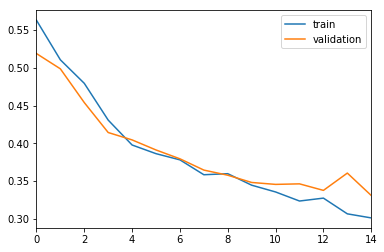

In [36]:
train_loss_series = pd.Series(mean_train_losses)
val_loss_series = pd.Series(mean_val_losses)
train_loss_series.plot(label="train")
val_loss_series.plot(label="validation")
plt.legend()

# Finally we compute our IOU score for various thresholds

In [37]:
y_pred_true_pairs = []
for images, masks in val_loader:
    images = Variable(images.cuda())
#     images = Variable(images)
    y_preds = model(images)
    for i, _ in enumerate(images):
        y_pred = y_preds[i] 
        y_pred = torch.sigmoid(y_pred)  # Sigmoid 归一化
        y_pred = y_pred.cpu().data.numpy()
        y_pred_true_pairs.append((y_pred, masks[i].numpy()))

In [38]:
print(len(y_pred_true_pairs))
print(y_pred_true_pairs[0][0].shape)
y_pred_true_pairs[0][0]

800
(1, 128, 128)


array([[[0.01644136, 0.03641307, 0.01310526, ..., 0.03854212,
         0.02770753, 0.00966435],
        [0.01628868, 0.5614665 , 0.47322586, ..., 0.48094523,
         0.38724765, 0.0194488 ],
        [0.01414377, 0.64167005, 0.68970406, ..., 0.416995  ,
         0.4020985 , 0.01641999],
        ...,
        [0.03782771, 0.5044611 , 0.63146144, ..., 0.7157817 ,
         0.6723614 , 0.01247625],
        [0.07653744, 0.435351  , 0.5688357 , ..., 0.59761125,
         0.6231467 , 0.0142095 ],
        [0.03605617, 0.03015498, 0.01834028, ..., 0.00889589,
         0.02333384, 0.00966807]]], dtype=float32)

We use a method to calculate the IOU score as found in this kernel here: https://www.kaggle.com/leighplt/goto-pytorch-fix-for-v0-3.

In [39]:
# https://www.kaggle.com/leighplt/goto-pytorch-fix-for-v0-3
for threshold in np.linspace(0, 1, 11):
    
    ious = []
    for y_pred, mask in y_pred_true_pairs:
        prediction = (y_pred > threshold).astype(int)
        iou = jaccard_similarity_score(mask.flatten(), prediction.flatten())
        ious.append(iou)
        
    accuracies = [np.mean(ious > iou_threshold)
                 for iou_threshold in np.linspace(0.5, 0.95, 10)]
    print('Threshold: %.1f, Metric: %.3f' % (threshold, np.mean(accuracies)))

Threshold: 0.0, Metric: 0.118
Threshold: 0.1, Metric: 0.476
Threshold: 0.2, Metric: 0.609
Threshold: 0.3, Metric: 0.703
Threshold: 0.4, Metric: 0.746
Threshold: 0.5, Metric: 0.766
Threshold: 0.6, Metric: 0.766
Threshold: 0.7, Metric: 0.757
Threshold: 0.8, Metric: 0.735
Threshold: 0.9, Metric: 0.703
Threshold: 1.0, Metric: 0.650


# 推断测试集

Load, predict and submit the test image predictions.

### 准备测试数据

In [40]:
#---------------  Get Training Images and resize train images and masks ------------------------------
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), im_height, im_width, 1), dtype=np.bool_)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    img = imread(path_test + '/images/' + id_)
    if n==1: 
        print("raw img shape:",img.shape)  # 打印其中的1张图片的原始shape   # 由于颜色数组中的RGB上对应的位置都相同 故可以只保存1个通道 压缩保存
    x = resize(img, (128, 128, 3), mode='constant', preserve_range=True)  # 缩放至128x128x1 
    X_test[n] = x

print('Done!')
print('X_test：',X_test.shape)
print("Y_test：",Y_test.shape)

Getting and resizing train images and masks ... 


A Jupyter Widget

raw img shape: (101, 101, 3)

Done!
X_test： (18000, 128, 128, 3)
Y_test： (18000, 128, 128, 1)


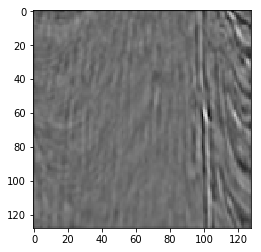

In [42]:
# Check if training data looks all right
ix = random.randint(0, len(test_ids))
plt.imshow(X_test[ix]) 
plt.show()

In [43]:
X_test_shaped = X_test.copy().reshape(-1, 3, 128, 128)/255  # 线性归一化 (0,1)区间
Y_test_shaped = Y_test.copy().reshape(-1, 1, 128, 128)

X_test_shaped = X_test_shaped.astype(np.float32)
Y_test_shaped = Y_test_shaped.astype(np.float32)

In [44]:
X_test_shaped=X_test_shaped.transpose(0,2,3,1)
Y_test_shaped=Y_test_shaped.transpose(0,2,3,1)
print("Before:",X_test_shaped.shape)

Before: (18000, 128, 128, 3)


In [45]:
X_test_shaped_1=np.zeros((X_test_shaped.shape[0],X_test_shaped.shape[3],X_test_shaped.shape[1],X_test_shaped.shape[2]),dtype=np.float32)
Y_test_shaped_1=np.zeros((Y_test_shaped.shape[0],Y_test_shaped.shape[3],Y_test_shaped.shape[1],Y_test_shaped.shape[2]),dtype=np.float32)

for idx,sample in tqdm_notebook(enumerate(X_test_shaped),total=len(X_test_shaped)):
    if idx==0:
        print(img_transform(sample).shape)  # 输入图片是【H,W,C】 转换结果是【C,H,W】
    #X_test_shaped_1[idx]=img_transform(sample)
    X_test_shaped_1[idx]= sample.transpose(2,0,1)
    
for idx,sample in tqdm_notebook(enumerate(Y_test_shaped),total=len(Y_test_shaped)):
    Y_test_shaped_1[idx]=sample.transpose(2,0,1)  # 不要对y进行标准归一化处理
    
print(X_test_shaped_1.shape)
print(X_test_shaped_1[0])
print(Y_test_shaped_1.shape)
print(Y_test_shaped_1[0])

A Jupyter Widget

torch.Size([3, 128, 128])



A Jupyter Widget


(18000, 3, 128, 128)
[[[-0.2855553  -0.2855553  -0.2855553  ... -1.0561693  -0.7136741
   -0.7136741 ]
  [-0.7136741  -0.37117907 -0.37117907 ... -0.33692956 -0.33692956
   -0.4054286 ]
  [-0.4054286  -0.4054286  -0.4739276  ... -0.6109256  -0.6109256
   -0.6109256 ]
  ...
  [-0.19993155 -0.19993155 -0.09718303 ... -0.30268008 -0.30268008
   -0.30268008]
  [ 0.43368444  0.43368444  0.43368444 ... -0.5424266  -0.6280504
   -0.6280504 ]
  [-0.6280504  -0.6109256  -0.6109256  ... -0.35405433 -0.35405433
   -0.19993155]]

 [[-0.07492995 -0.07492995  0.01260505 ... -0.23249297 -0.23249297
   -0.23249297]
  [ 0.50280124  0.50280124  0.50280124 ... -0.495098   -0.582633
   -0.582633  ]
  [-0.582633   -0.565126   -0.565126   ... -0.24999997 -0.24999997
   -0.10994396]
  ...
  [ 1.3781513   1.4131653   1.4131653  ...  0.06512605  0.06512605
    0.06512605]
  [ 0.06512605  0.06512605 -0.07492995 ... -0.547619   -0.547619
   -0.547619  ]
  [-1.5980392  -1.5980392  -1.5980392  ...  1.2380953   1.


[如何手动释放Python的内存](https://blog.csdn.net/ztf312/article/details/54024765)

In [46]:
import gc 

del X_test_shaped
del Y_test_shaped
del X_test
del Y_test
gc.collect() 

0

## 水平翻转测试集

In [47]:
X_test_shaped_2 =X_test_shaped_1.copy()
Y_test_shaped_2=Y_test_shaped_1.copy()
print(X_test_shaped_2 is X_test_shaped_1)
print(Y_test_shaped_2 is Y_test_shaped_1)

print(X_test_shaped_2.shape)
print(Y_test_shaped_2.shape)

def Flip(X,Y):
#     X_aug = bb[:,::-1,:]
#     y_aug = cc[:,::-1,:]  
    X_aug = X[:,:,:,::-1]
    y_aug = Y[:,:,:,::-1]  
    return X_aug,y_aug

X_test_shaped_2,Y_test_shaped_2=Flip(X_test_shaped_2,Y_test_shaped_2)

False
False
(18000, 3, 128, 128)
(18000, 1, 128, 128)


In [48]:
X_test_shaped_3=np.concatenate([X_test_shaped_1,X_test_shaped_2],axis=0)
Y_test_shaped_3=np.concatenate([Y_test_shaped_1,Y_test_shaped_2],axis=0)

In [49]:
print(X_test_shaped_3.shape)
print(Y_test_shaped_3.shape)

(36000, 3, 128, 128)
(36000, 1, 128, 128)


### 加载待测试模型

In [50]:
salt_ID_dataset_test = saltIDDataset(X_test_shaped_3, 
                                      train=True,   # 在bug没修正前，不要设置为False
                                      preprocessed_masks=Y_test_shaped_3)

batch_size = 64

test_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_test, 
                                           batch_size=batch_size, 
                                           shuffle=False)


In [51]:
salt_ID_dataset_test.__len__()

36000

In [52]:
Mask_preds = []
count=1
for images,_ in test_loader:
    
    count=count+1
    if count%20==0:
        print("Next 20 Test Batchs ...")
        
    images = Variable(images.cuda())
    masks = Variable(masks.cuda())
#     images = Variable(images)
    y_preds= model(images)

    for i, _ in enumerate(images):
        y_pred = y_preds[i] 
        y_pred = torch.sigmoid(y_pred)  # Sigmoid 归一化
        y_pred = y_pred.cpu().data.numpy()
        Mask_preds.append(y_pred)    
        # 可以通过numpy pandas 等写入disk
        
print("Test Done!")

Next 20 Test Batchs ...
Next 20 Test Batchs ...
Next 20 Test Batchs ...
Next 20 Test Batchs ...
Next 20 Test Batchs ...
Next 20 Test Batchs ...
Next 20 Test Batchs ...
Next 20 Test Batchs ...
Next 20 Test Batchs ...
Next 20 Test Batchs ...
Next 20 Test Batchs ...
Next 20 Test Batchs ...
Next 20 Test Batchs ...
Next 20 Test Batchs ...
Next 20 Test Batchs ...
Next 20 Test Batchs ...
Next 20 Test Batchs ...
Next 20 Test Batchs ...
Next 20 Test Batchs ...
Next 20 Test Batchs ...
Next 20 Test Batchs ...
Next 20 Test Batchs ...
Next 20 Test Batchs ...
Next 20 Test Batchs ...
Next 20 Test Batchs ...
Next 20 Test Batchs ...
Next 20 Test Batchs ...
Next 20 Test Batchs ...
Test Done!


In [53]:
len(Mask_preds)

36000

In [54]:
Mask_preds_part1=Mask_preds[0:18000].copy()
Mask_preds_part2=Mask_preds[18000:].copy()
print(len(Mask_preds_part1))
print(len(Mask_preds_part2))

def Flip_img(Mask): #[bs,c_in,H,W]
    out=[]
    for i in range(len(Mask)):
        out.append( Mask[i][:,:,::-1].copy()) 
    return out

Mask_preds_part2= Flip_img(Mask_preds_part2)


18000
18000


In [55]:
len(Mask_preds)

36000

In [56]:
import gc 

del Mask_preds

gc.collect() 


Mask_preds=[]
for i in range(len(Mask_preds_part1)):
    Mask_preds.append(0.5*(Mask_preds_part1[i]+Mask_preds_part2[i]))
print("平均ok,Mask_preds shape:",len(Mask_preds))

平均ok,Mask_preds shape: 18000


In [57]:
print("Mask_preds shape:",len(Mask_preds))
print(Mask_preds[0].shape)

Mask_preds shape: 18000
(1, 128, 128)


### 持久化预测的Mask_preds 以便后续探索各种阈值截断方式

![](http://op4a94iq8.bkt.clouddn.com/18-8-28/6311537.jpg)

In [58]:
import gc 

del X_test_shaped_1
del Y_test_shaped_1

gc.collect() 

np.save('Mask_preds_128',Mask_preds)

In [59]:
import pickle
f1 = open('test_ids.pkl', 'wb')  
pickle.dump(test_ids,f1,0)# 1或者2为二进制保存
f1.close()

# 制作submission.csv

In [60]:
f1 = open('test_ids.pkl', 'rb')
test_ids=pickle.load(f1)  #重新载入
f1.close()

In [61]:
# 载入 mask predication
Mask_preds=np.load('Mask_preds_128.npy")

SyntaxError: EOL while scanning string literal (<ipython-input-61-7803472688fd>, line 2)

In [58]:

Mask_preds_101=np.zeros((len(Mask_preds),101,101),dtype=np.float)
for idx,sample in tqdm_notebook(enumerate(Mask_preds),total=len(Mask_preds)):
    # 把128x128的转换到101x101
    
    Mask_preds_101[idx] = resize(sample, (1,101, 101), mode='constant', preserve_range=True).reshape(101,101)
print("Mask_preds_101 shape:",len(Mask_preds_101))
print(Mask_preds_101[0].shape)

A Jupyter Widget


Mask_preds_101 shape: 18000
(101, 101)


In [59]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth

# 对二值化的mask矩阵进行run-length编码
def RunLengthEncode(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [62]:
threshold=0.8

pred_dict = {fn[:-4]:RunLengthEncode((Mask_preds_101[i]>threshold).astype(np.bool_)) for i,fn in tqdm_notebook(enumerate(test_ids),total=len(Mask_preds_101))}

A Jupyter Widget

In [63]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')